Análise de Séries Temporais - O modelo ARIMA
============================================

Professor: Marcos Cesar Gritti
Email: cesargritti@gmail.com

Esta notebook exemplifica a metodologia Box & Jenkins para modelagem de séries temporais. Tem como objetivo principal a criação de intuição em análise e mineração de séries temporais, e apresenta ferramentas / técnicas utilizadas para caracterizar uma série temporal (estacionaridade, sazonalidade, linearidade) e para estimação de modelos preditivos.

Neste módulo vamos aprender sobre:
 1. **Modelo AR - Mínimos Quadrados**;
 2. **Modelo ARMA - Mínimos Quadrados Recursivo**;
 3. **Modelo ARIMA - Biblioteca Scipy**;

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

sns.set(
    style="whitegrid",
    rc={"figure.figsize": (14, 8), "lines.linewidth": 2, "figure.dpi": 100},
    font_scale=1.25,
    
)

In [83]:
# Definição de algumas funções utilitárias que utilizaremos neste notebook
def plot_ts(t, y, e):
    """Visualização série temporal.
    
    :param t: Vetor tempo
    :param y: Série temporal
    :param e: Ruído sintético
    """
    plt.subplot(211)
    plt.plot(t, y)
    plt.title("Série")
    
    plt.subplot(212)
    plt.plot(t, e)
    plt.ylabel("Ruído branco")
    plt.xlabel("Amostra")
    
def plot_osa(t, y, p, e, r):
    """Visualização da predição 1 passo à frente (OSA, One Step Ahead).
    
    :param t: Vetor tempo
    :param y: Série temporal
    :param p: Predição 1 passo a frente
    :param e: Ruído sintético
    :param r: Resíduo
    """
    plt.subplot(211)
    plt.plot(t, y, t, p)
    plt.title("Série")
    plt.legend(["Original", "Predição 1 Passo à Frente"])

    plt.subplot(212)
    plt.plot(t, e, t, r)
    plt.legend(["Ruído Branco", "Resíduo do Modelo"])


def plot_corr(y, title=""):
    """Funções de autocorrelação da série temporal"""
    plt.figure()
    ax = plt.subplot(211)
    plot_acf(y, ax=ax, title=title)
    plt.ylabel("ACF")
    
    ax = plt.subplot(212)
    plot_pacf(y, ax=ax, title="", method="ywm")
    plt.ylabel("Partial ACF")

def norm_loglike(r):
    samples = len(r)
    ssr = ((r - r.mean()) ** 2).sum()
    sigma2 = ssr / (samples - 1)
    
    return (- (samples * np.log(sigma2) / 2)
            - (samples * np.log(2 * np.pi) / 2)
            - ssr / (2 * sigma2))

def aic(r, k):
    """Critério de informação de Akaike"""
    return 2 * k - 2 * norm_loglike(r)

def bic(r, k):
    """Critério de informação Bayesiano"""
    return np.log(len(r)) * k - 2 * norm_loglike(r)

def print_aftest(r):
    """Função utilitária para apresentar em tela os resultados do teste de Augmented Dickey-Fuller para
    detecção de estacionaridade"""
    tv, pv, _, _, _, _ = adfuller(r)
    print(f"""Augmented Dickey-Fuller: Valor = {tv:.2f}, P-Value = {pv:.2f}""")
    
def print_equation(equation, r):
    """Função utilitária para apresentar os resultados finais de um modelo"""
    tv, pv, _, _, _, _ = adfuller(r)
    print(f"""
Augmented Dickey-Fuller  ~  Valor = {tv:.2f}, P-Value = {pv:.2f}
Equação estimada         ~  yp[k] = {equation}
Erro médio quadrático    ~  {(r ** 2).mean():.4f}
AIC                      ~  {aic(r, 1):.4f}
BIC                      ~  {bic(r, 1):.4f}
    """)

Processo ARIMA(0, 1, 0) ~ Passeio aleatório
-------------------------------------------

O modelo de passeio aleatório (chamado na literatura de Random Walk), é definido pela seguinte equação:

\begin{equation}
y_k = y_{k-1} + \xi_{k}
\end{equation}

Augmented Dickey-Fuller: Valor = -0.70, P-Value = 0.85


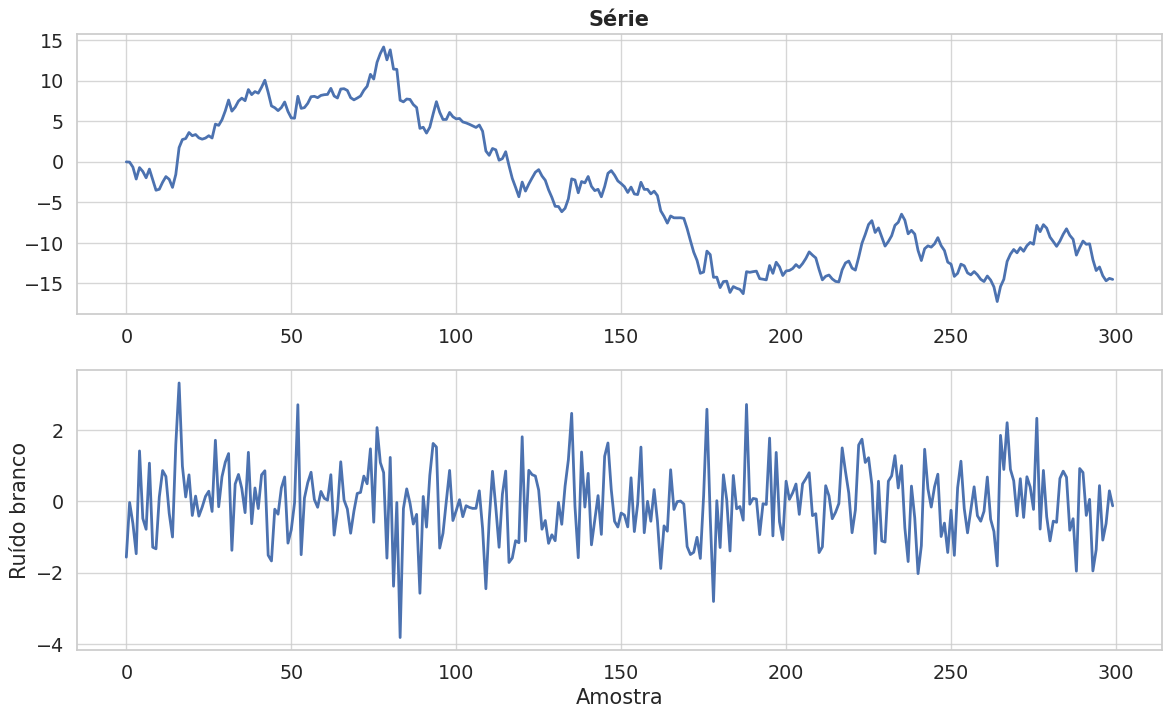

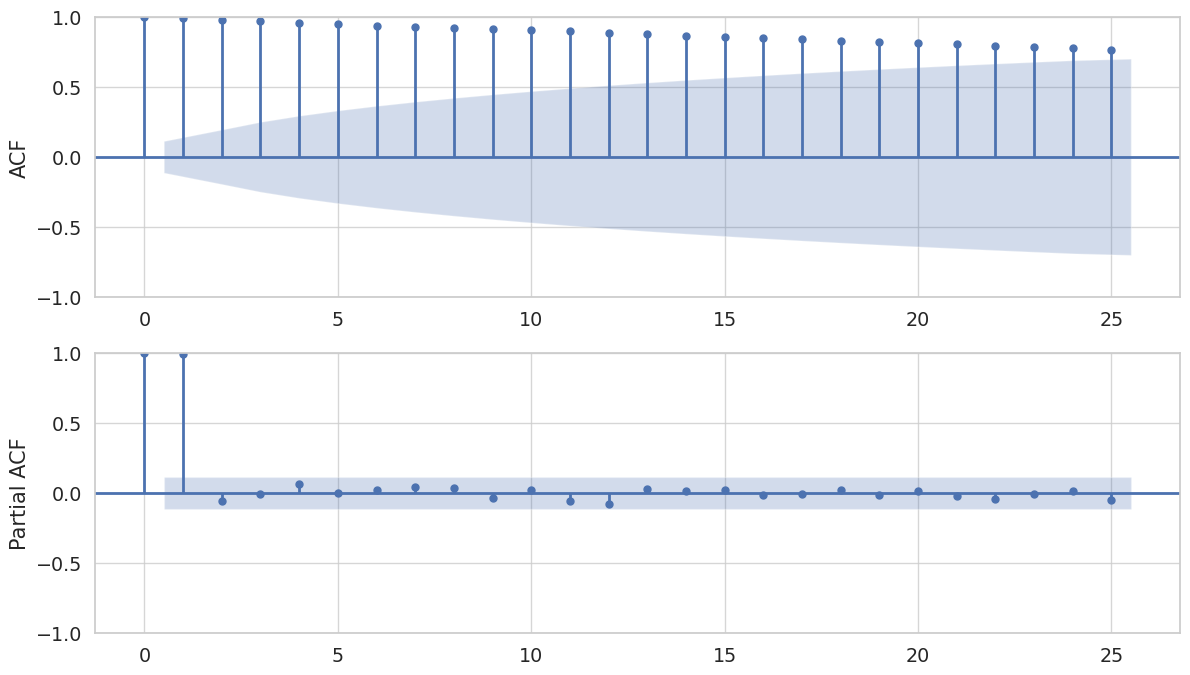

In [84]:
random.seed(50)
np.random.seed(50)
samples = 300

t = np.arange(samples)
y = np.zeros((samples, 1))
e = np.random.randn(samples, 1) # Ruído branco: média 0, desvio padrão 1

# gerando a série temporal programaticamente
for k in range(1, samples):
    y[k] = 1.0 * y[k-1] + e[k]
    
plot_ts(t, y, e) # função utilitária para visualizar a serie
plot_corr(y)     # visualização do acf e pafc da série original
print_aftest(y)

podemos observar, por meio da ACF, que a série temporal não é estacionária. Vejamos o que acontece com as visualizações do ACF e PACF quando diferenciamos a série:

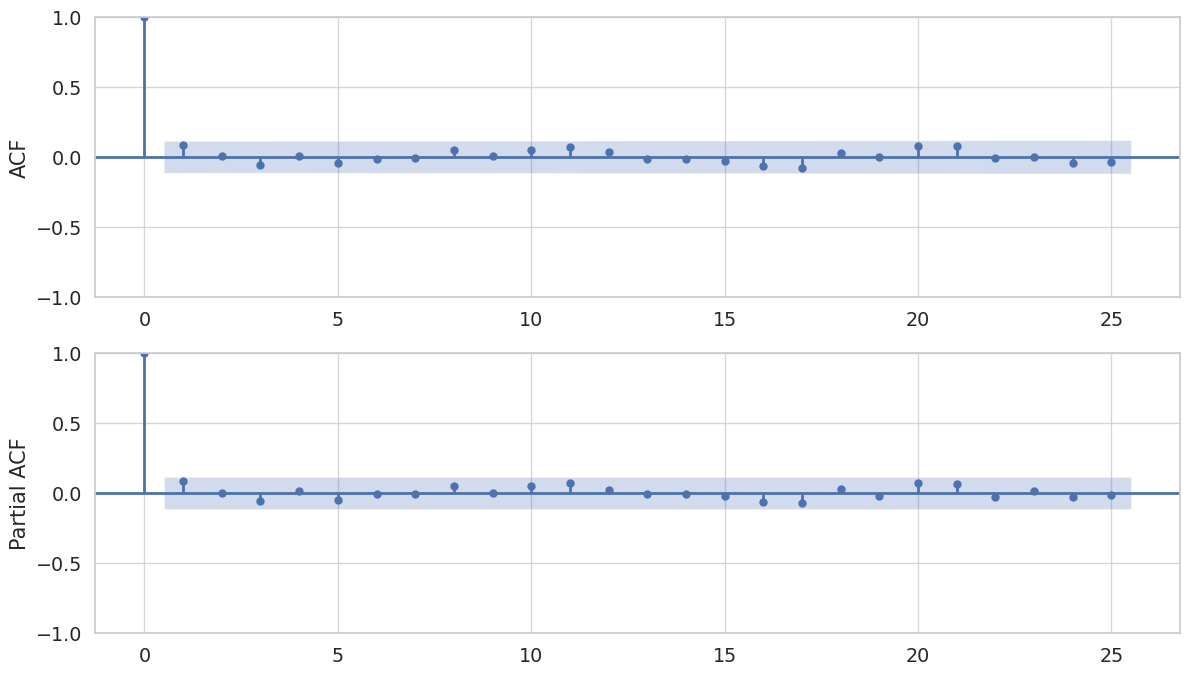

In [85]:
z = np.diff(y, axis=0)
plot_corr(z) # visualização do acf e pafc da série diferenciada

podemos observar que nenhum *LAG* está correlacionado entre si, após a diferenciação. Logo, podemos definir que a equação final de predição de nosso modelo se dá por:

\begin{equation}
y_k = y_{k-1}
\end{equation}

vamos calcular o vetor de predições para sumarizar os resutlados da análise desta séria.


Augmented Dickey-Fuller  ~  Valor = -15.87, P-Value = 0.00
Equação estimada         ~  yp[k] = +1.00y[k-1]
Erro médio quadrático    ~  1.0292
AIC                      ~  861.3284
BIC                      ~  865.0322
    


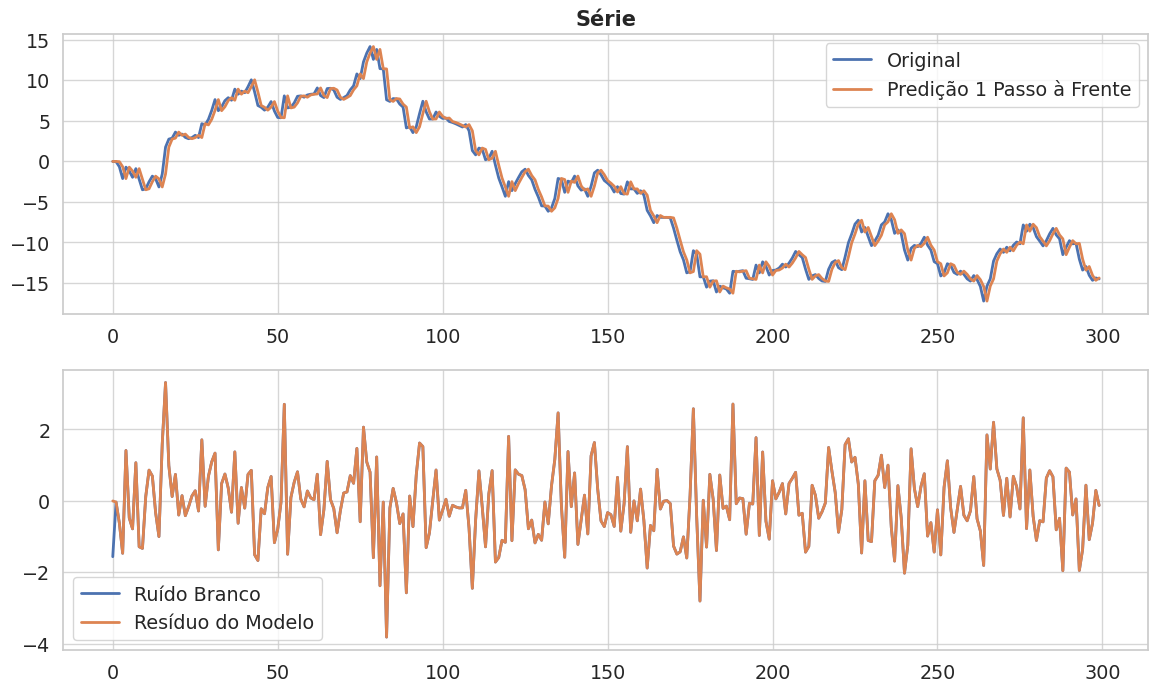

In [86]:
p = np.zeros_like(y)

for k in range(1, samples):
    p[k] = y[k-1]
    
r = y - p
plot_osa(t, y, p, e, r)
print_equation("+1.00y[k-1]", r)

Processo ARIMA(1, 0, 0) ~ AR(1) - Mínimos Quadrados
-----------------------------------------------

Começaremos hoje aprendendo a estimar os coeficientes de um modelo Auto-Regressivo [AR(1)] para uma Série Termporal sintética descrita pela equação:

\begin{equation}
    y_k = 0.6 y_{k-1} + \xi_k
\end{equation}

onde $\xi_k \sim N(0, 1)$, utilizando o Método dos Mínimos Quadrados.

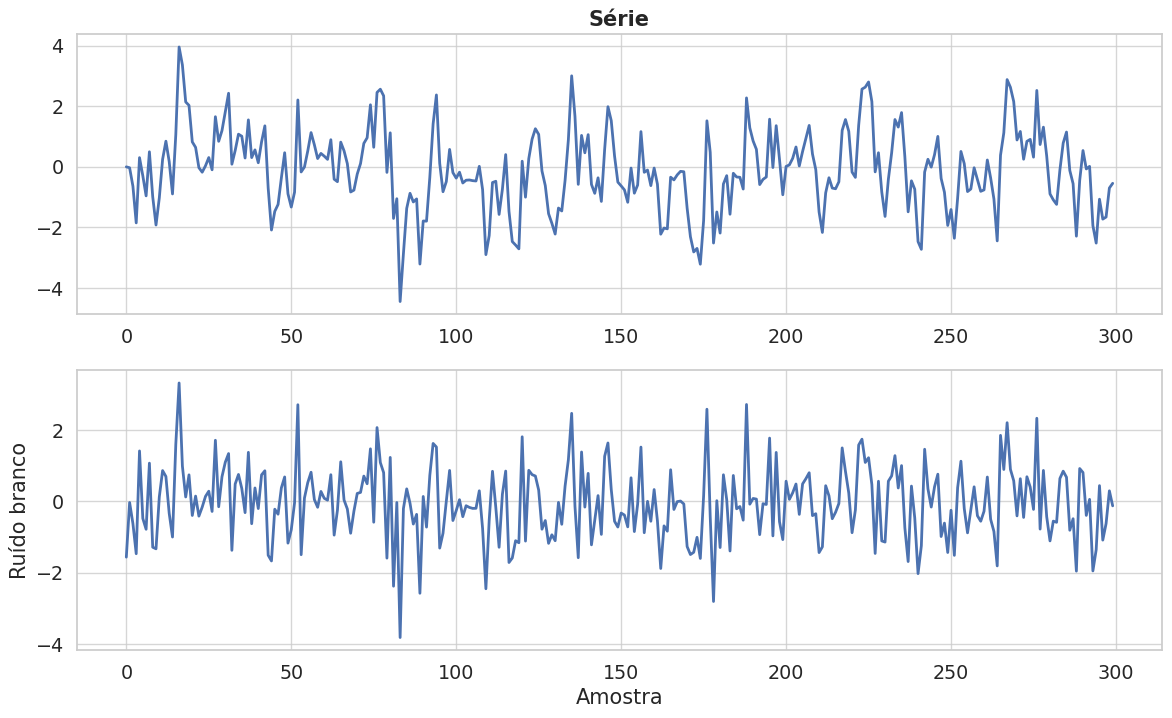

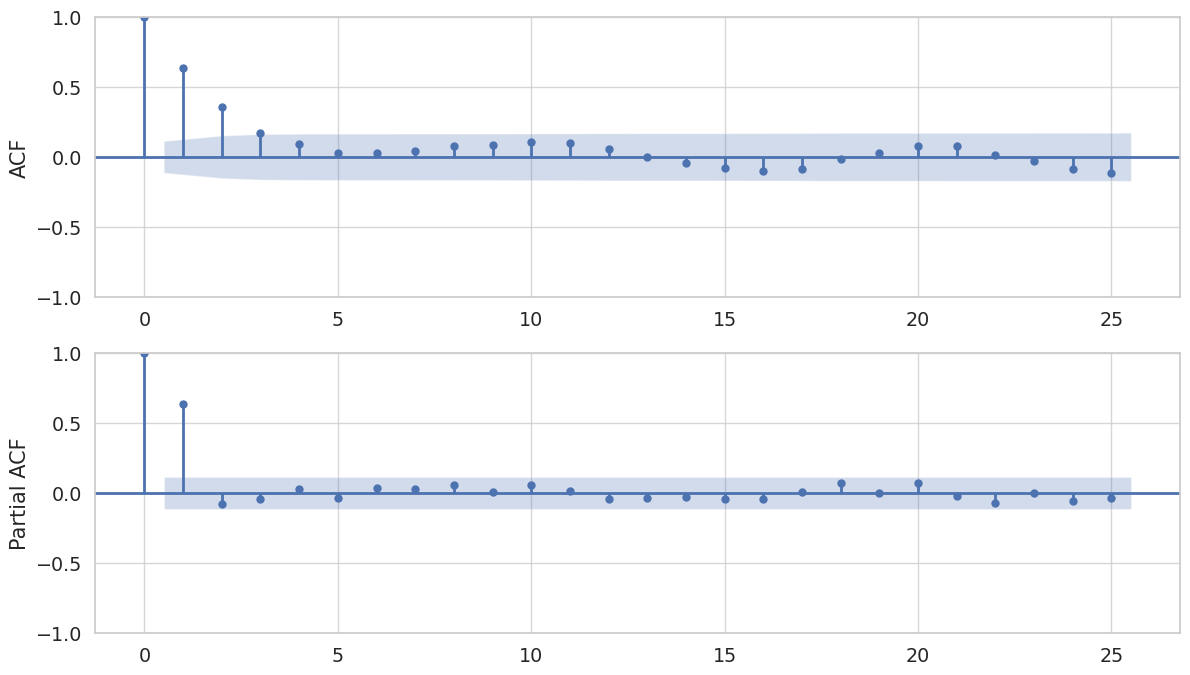

In [87]:
random.seed(50)
np.random.seed(50)

samples = 300

t = np.arange(samples)
y = np.zeros((samples, 1))
e = np.random.randn(samples, 1) # Ruído branco: média 0, desvio padrão 1

# gerando a série temporal programaticamente
for k in range(1, samples):
    y[k] = 0.6 * y[k-1] + e[k] 
    
plot_ts(t, y, e) # função utilitária para visualizar a serie
plot_corr(y)     # visualização do acf e pafc da série original 

Aparentemente, a série temporal é estacionária. Nota-se, pela visualização do PACF, que um possível modelo parsimônico inclui um termo auto-regressivo [AR(1)]. Obs.: A visualização da ACF indica que podemos utilizar [MA(3)], contudo, vamos testar, primeiramento, o modelo que incluir apenas 1 termo auto-regressivo e verificar se a inclusão do mesmo é suficiente para garantir a observação de uma distribuição gaussiana no resíduo resultante.

Organizando a matriz design

neste caso temos:
\begin{equation}
\vec{y} = [y_1, \ldots, y_N]^T
\end{equation}

\begin{equation}
Y = \left[
\begin{array}[c]
  \. y_2 \\
  \vdots \\
  y_N
\end{array}
\right]
\end{equation}

\begin{equation}
X = \left[
\begin{array}[c]
  \. y_1 \\
  \vdots \\
  y_{N-1}
\end{array}
\right]
\end{equation}


Augmented Dickey-Fuller  ~  Valor = -16.46, P-Value = 0.00
Equação estimada         ~  yp[k] = +0.64 y[k-1]
Erro médio quadrático    ~  1.0268
AIC                      ~  860.7288
BIC                      ~  864.4325
    


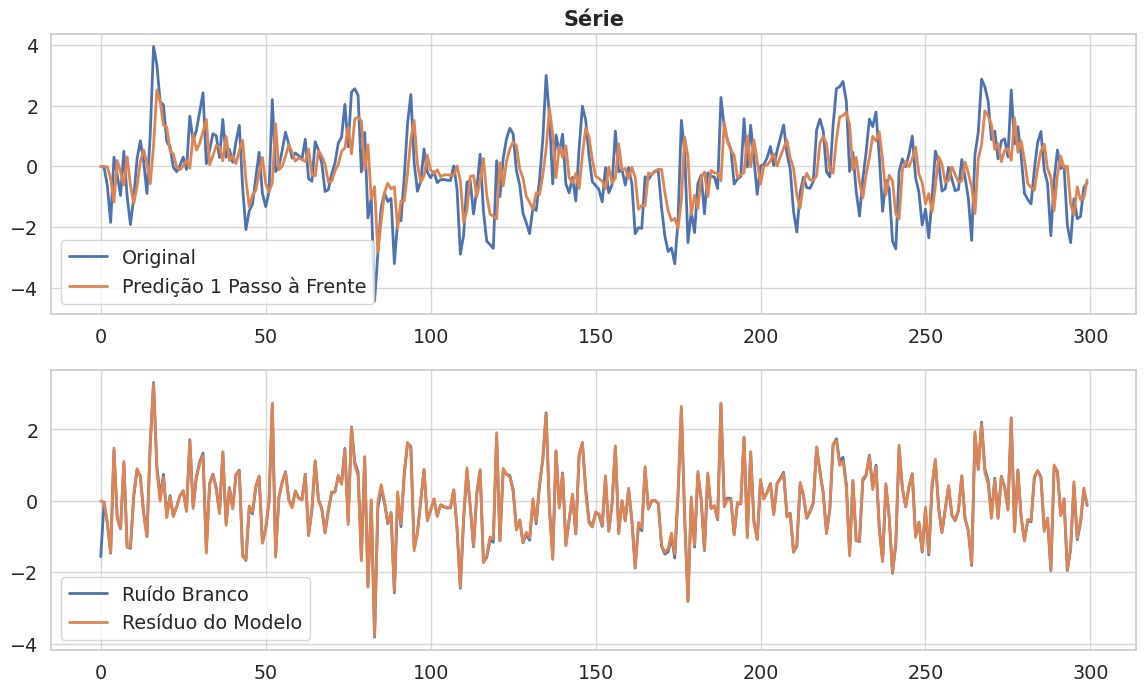

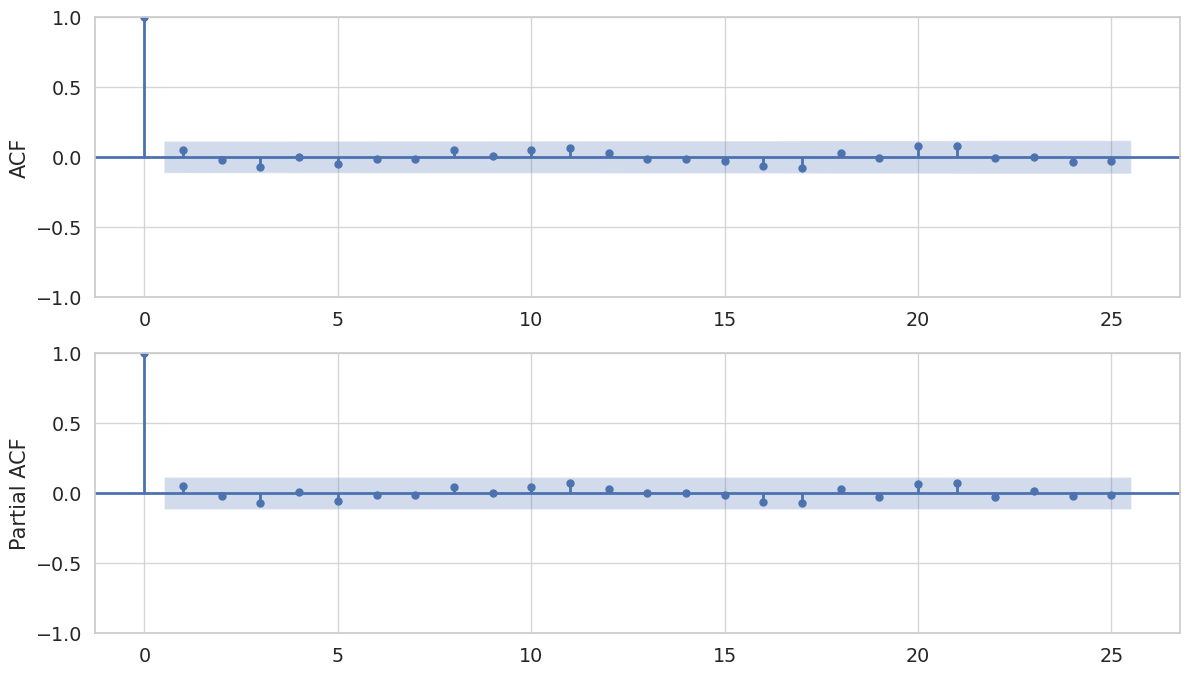

In [89]:
Y = y[1:]
X = np.hstack([y[:-1]])

W = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(Y)

y_pred = np.vstack([0, X.dot(W)])
r = y - y_pred

plot_osa(t, y, y_pred, e, r)
plot_corr(r) # visualizando acf e pacf na série final de resíduos
print_equation(f"{W[0][0]:+.2f} y[k-1]", r)

Processo ARIMA(1, 0, 1) ~ ARMA(1, 1) - Mínimos Quadrados Recursivos
---------------------------------------------------------------------

\begin{equation}
    y_k = 0.5 y_{k-1} + 0.6 \xi_{k-1} + \xi_k
\end{equation}

onde $\xi_k \sim N(0, 1)$

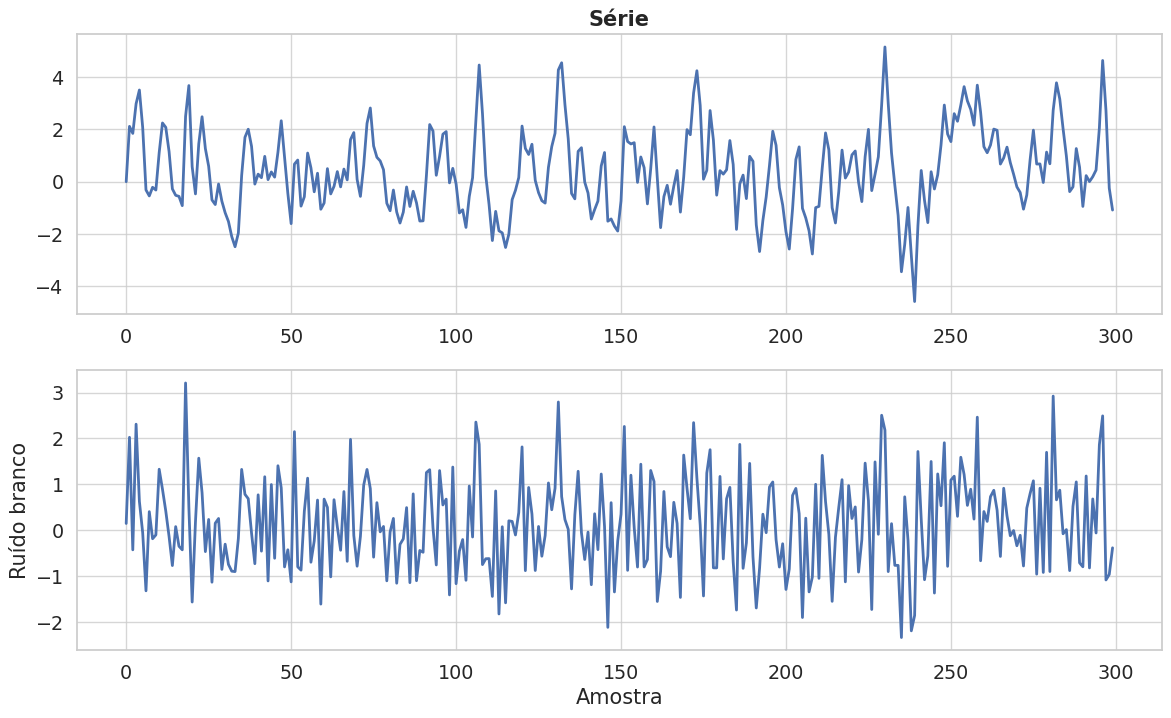

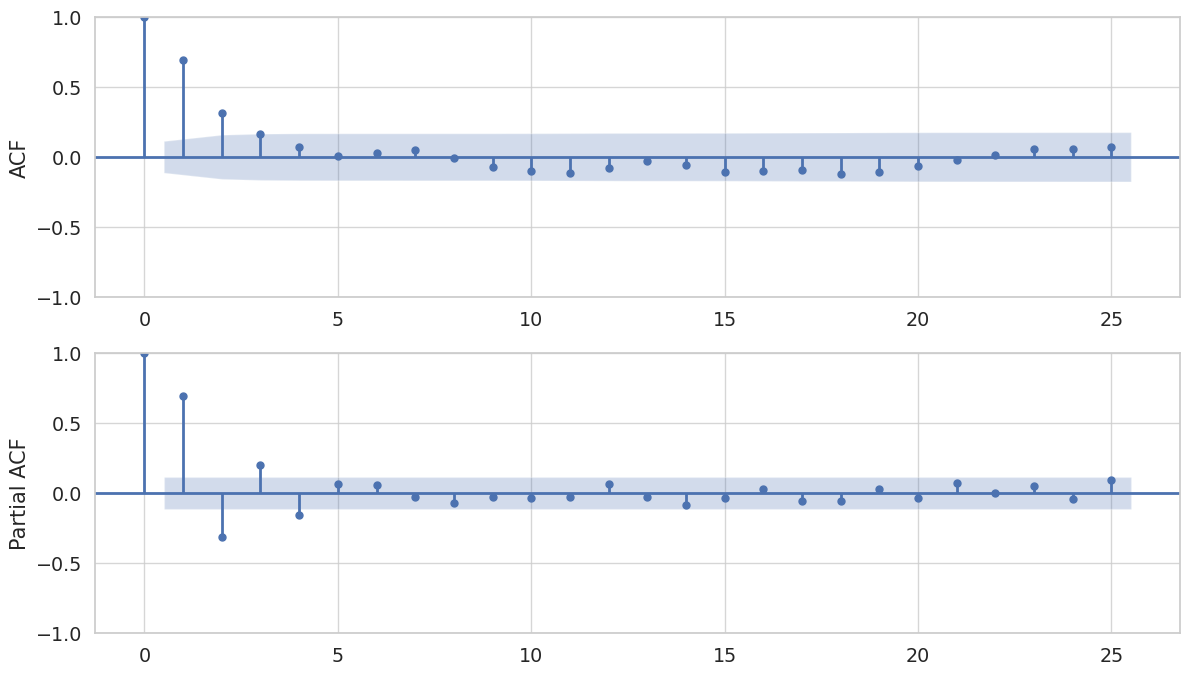

In [98]:
random.seed(120)
np.random.seed(120)

samples = 300

t = np.arange(samples)
y = np.zeros((samples, 1))
e = np.random.randn(samples, 1)

for k in range(1, samples):
    y[k] = 0.5 * y[k-1] + 0.6 * e[k-1] + e[k]

plot_ts(t, y, e)
plot_corr(y)

In [100]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

def compare_models(y, orders):
    models = []
    for order in orders:
        model = ARIMA(y, order=order)
        resul = model.fit()
        models.append([order, resul.aic, resul.bic])
    df = pd.DataFrame(models, columns=["order", "aic", "bic"])
    return df.set_index("order").sort_values(by="aic")

models = compare_models(y, [
    (1, 0, 0),
    (1, 0, 1),
    (1, 0, 2),
    (2, 0, 0),
    (2, 0, 1),
    (2, 0, 2),
    (3, 0, 0),
    (3, 0, 1),
    (3, 0, 2),
    (4, 0, 0),
    (4, 0, 1),
    (4, 0, 2),
    (0, 0, 1),
    (0, 0, 2),
    (0, 0, 3),
])

models

,aic,bic
order,,
"(1, 0, 1)",880.220148,895.035278
"(1, 0, 2)",882.199467,900.718379
"(2, 0, 1)",882.205840,900.724752
"(4, 0, 0)",882.629867,904.852562
"(2, 0, 2)",883.539822,905.762517
"(3, 0, 1)",883.613376,905.836071
"(4, 0, 1)",883.719221,909.645698
"(0, 0, 2)",884.642769,899.457899
"(0, 0, 3)",884.645791,903.164704



Augmented Dickey-Fuller  ~  Valor = -10.28, P-Value = 0.00
Equação estimada         ~  yp[k] = +0.71 y[k-1]
Erro médio quadrático    ~  1.2834
AIC                      ~  925.0106
BIC                      ~  928.7144
    


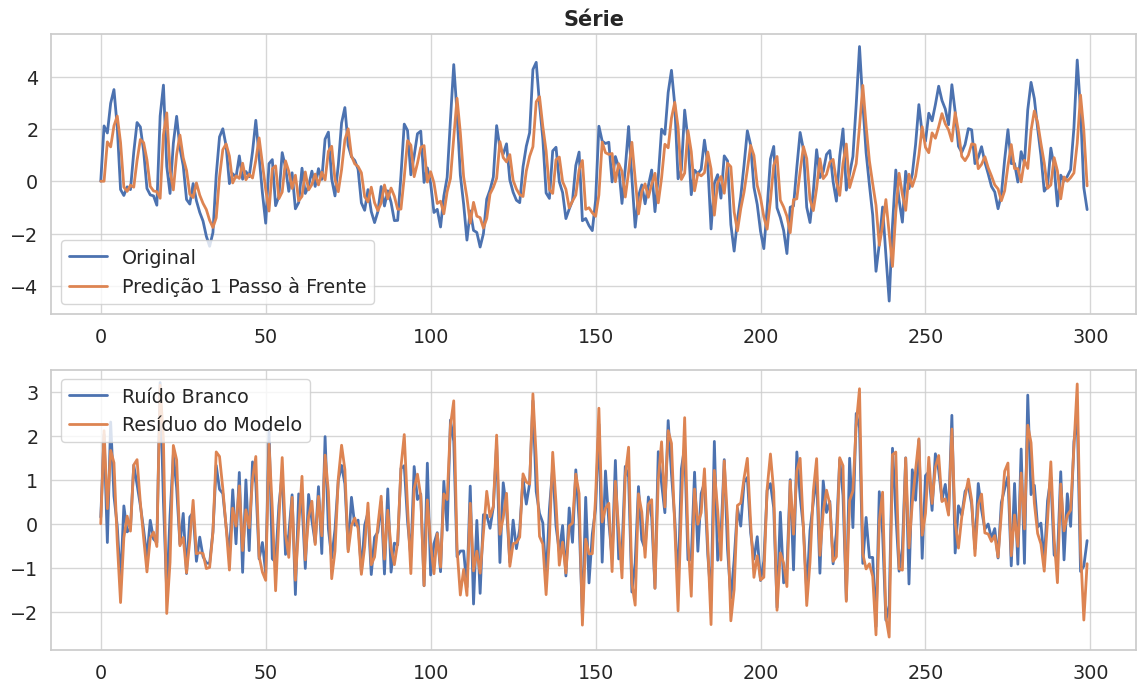

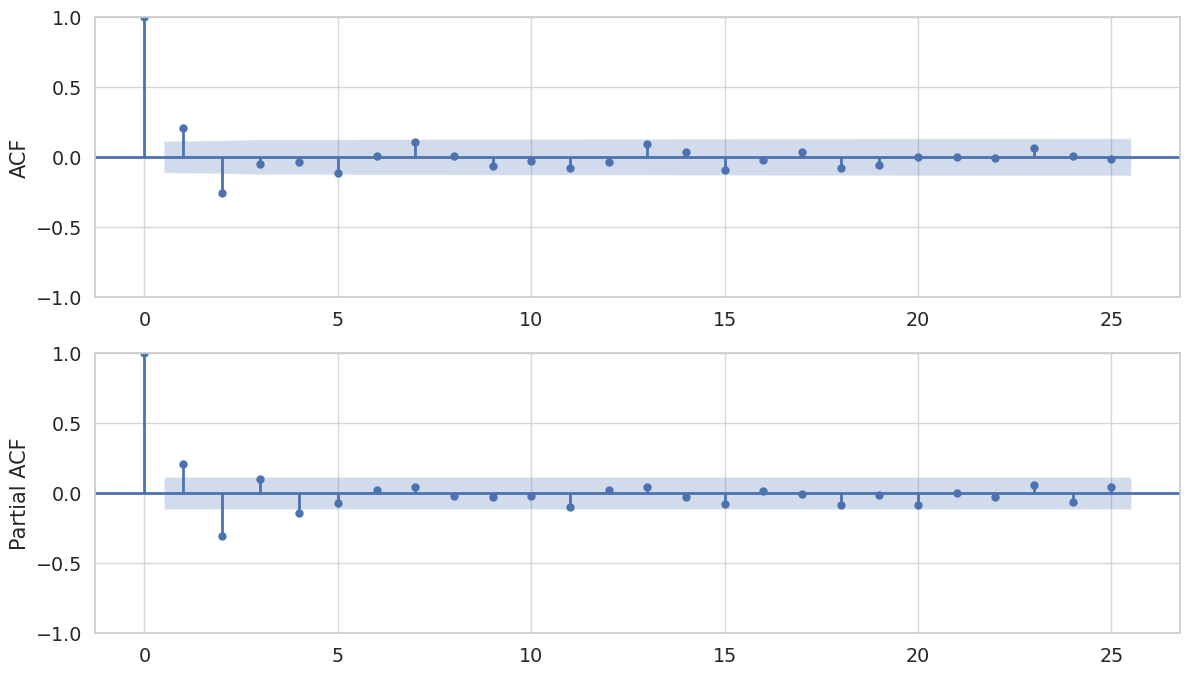

In [105]:
Y = y[1:]
X = np.hstack([y[:-1]])

W = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(Y)

y_pred = np.vstack([0, X.dot(W)])
r = y - y_pred

plot_osa(t, y, y_pred, e, r)
plot_corr(r)
print_equation(f"{W[0][0]:+.2f} y[k-1]", r)


Augmented Dickey-Fuller  ~  Valor = -17.54, P-Value = 0.00
Equação estimada         ~  yp[k] = +0.48 y[k-1] +0.55 e[k-1]
Erro médio quadrático    ~  1.0926
AIC                      ~  874.7048
BIC                      ~  878.4085
    


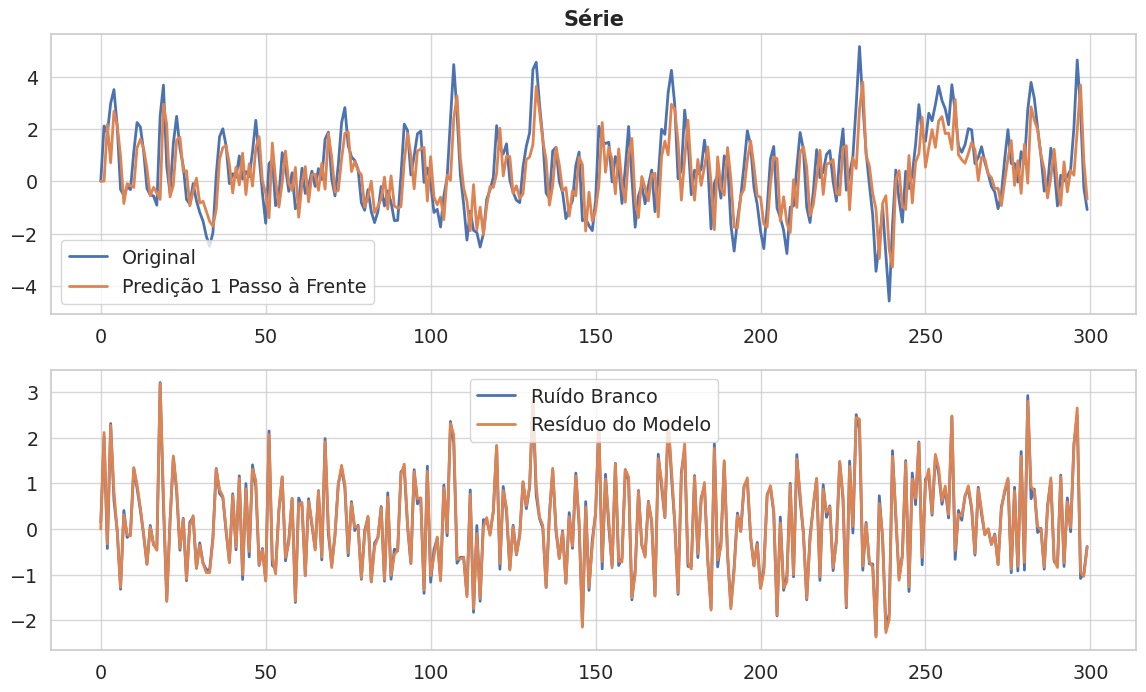

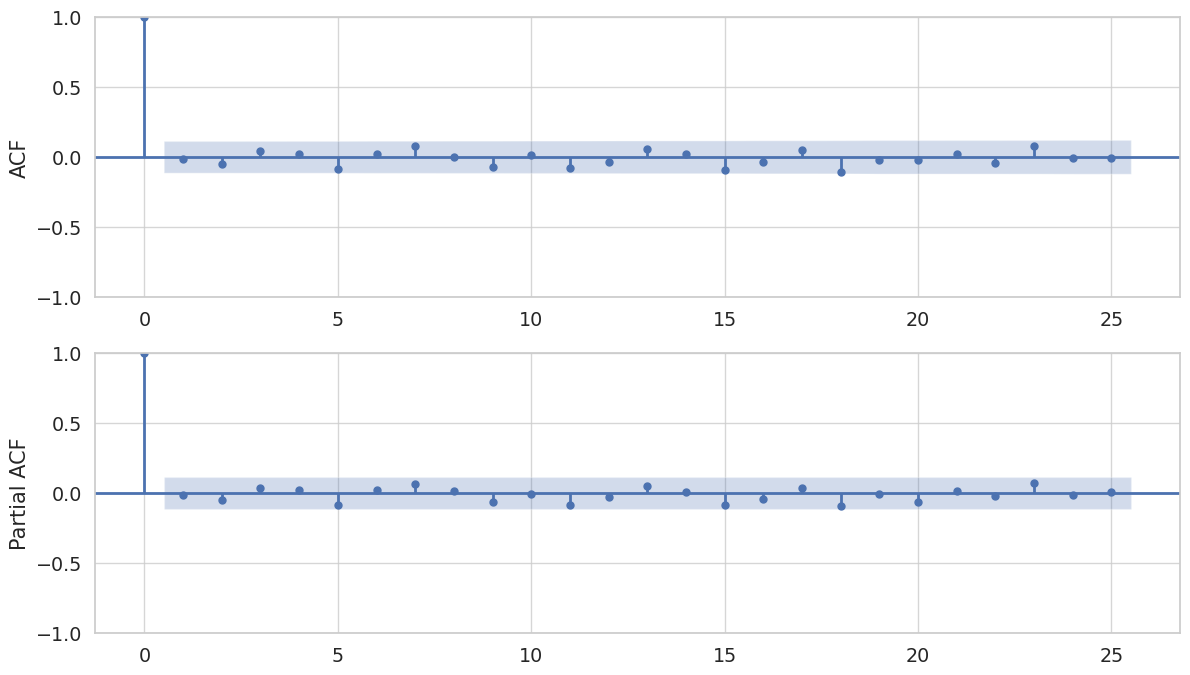

In [106]:
# Começamos assumindo que o resíduo é nulo
r = np.zeros_like(y)

# Inicializamos o vetor `target` (saída desejada)
Y = y[1:]

# Repetimos, 10 vezes, a estimativa dos parâmetros
for _ in range(10):
    X = np.hstack([y[:-1], r[:-1]])
    W = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(Y)
    y_pred = np.vstack([0, X.dot(W)])
    r = y - y_pred

plot_osa(t, y, y_pred, e, r)
plot_corr(r)
print_equation(f"{W[0][0]:+.2f} y[k-1] {W[1][0]:+.2f} e[k-1]", r)

Processo ARIMA(1, 1, 1) - Mínimos Quadrados Recursivos
----------------------------------------------------------------------

\begin{equation}
    z_k = y_k - y_{k-1}
\end{equation}
\begin{equation}
    z_k = 0.6 z_{k-1} + 0.4 \xi_{k-1} + \xi_k
\end{equation}

onde $\xi_k \sim N(0, 1)$

Note que se substituir-mos a primeira equação na segunda, obtemos o processo:

\begin{equation}
    y_{k} - y_{k-1} = 0.6 (y_{k-1} - y_{k-2}) + 0.4 \xi_{k-1} + \xi_k
\end{equation}

\begin{equation}
    y_{k} = 1.6 y_{k-1} - 0.6 y_{k-2} + 0.4 \xi_{k-1} + \xi_k
\end{equation}

Augmented Dickey-Fuller: Valor = -0.28, P-Value = 0.93
Augmented Dickey-Fuller: Valor = -7.74, P-Value = 0.00


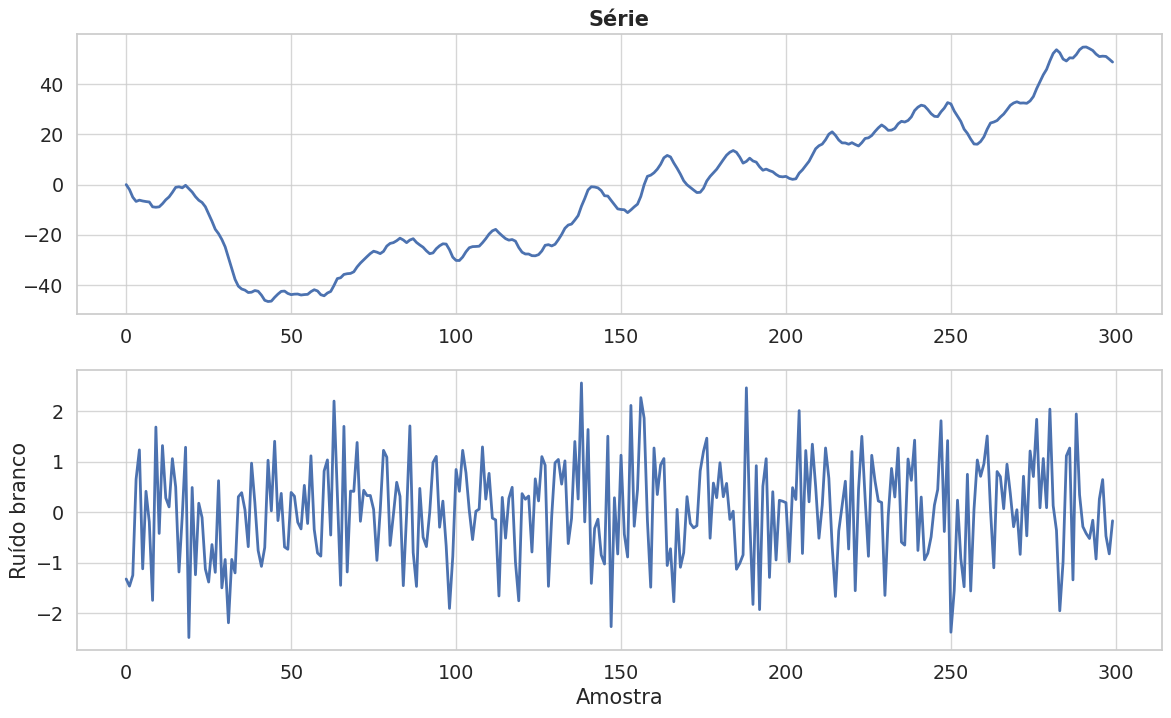

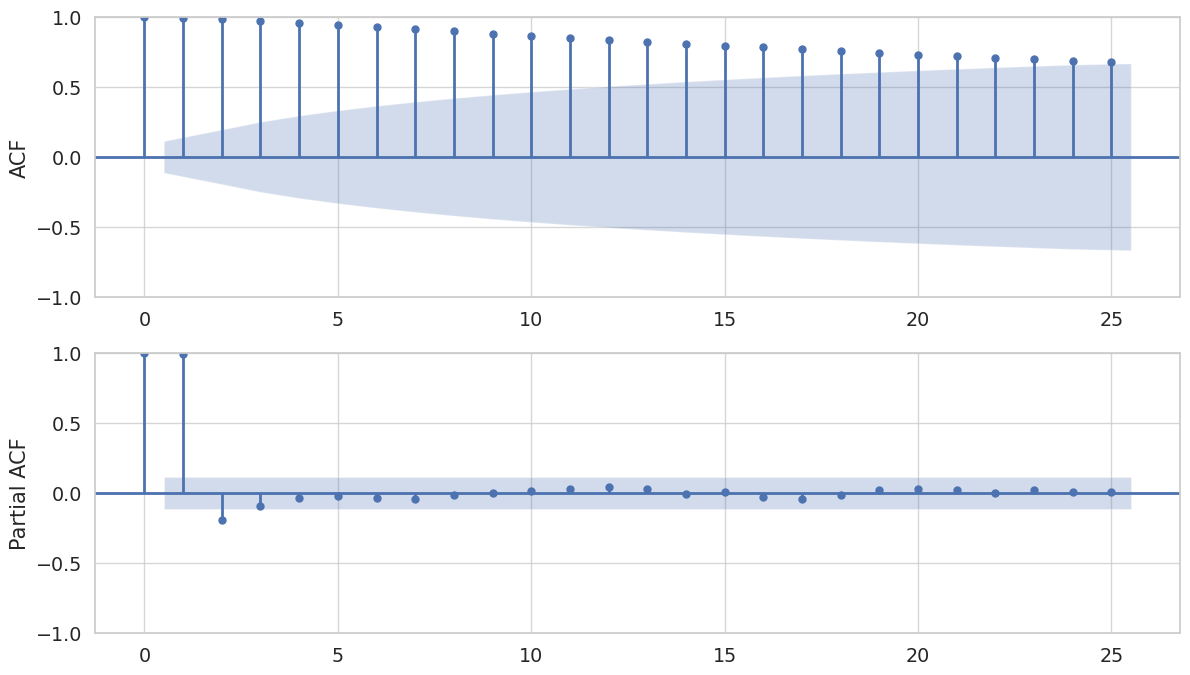

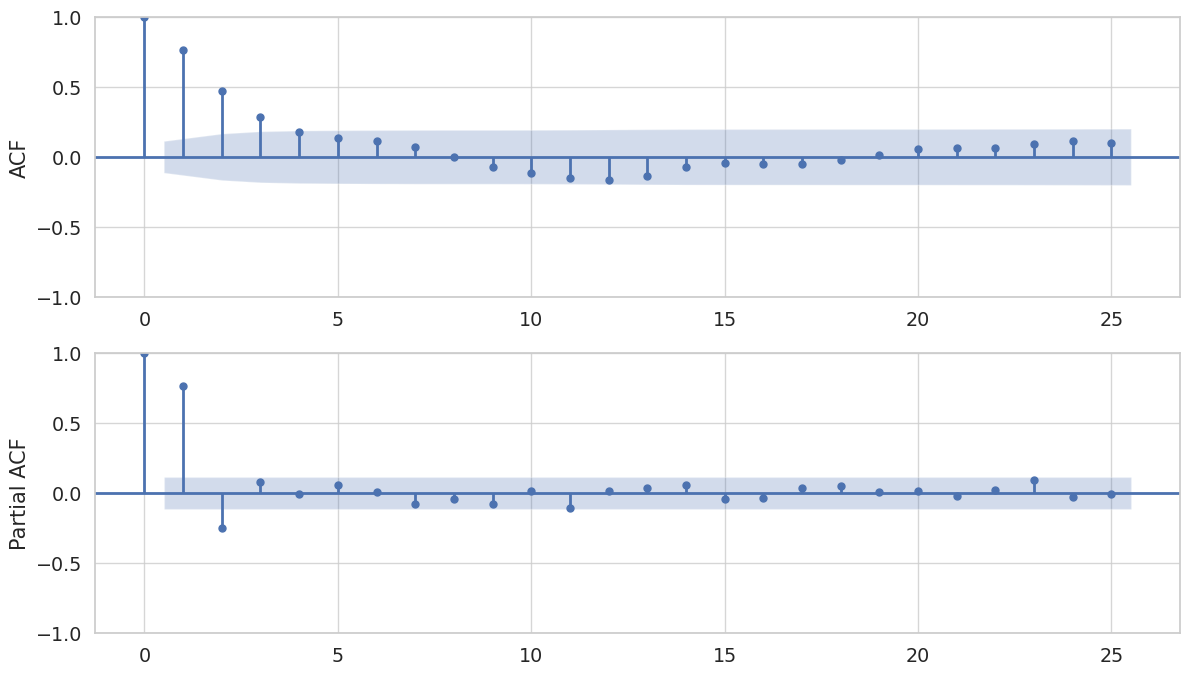

In [111]:
random.seed(220)
np.random.seed(220)

samples = 300

t = np.arange(samples)
y = np.zeros((samples, 1))
z = np.zeros((samples, 1))
e = np.random.randn(samples, 1)

for k in range(1, samples):
    z[k] = 0.6 * z[k-1] + 0.4 * e[k-1] + e[k]
    y[k] = y[k-1] + z[k]

plot_ts(t, y, e)
plot_corr(y)
plot_corr(z)
print_aftest(y)
print_aftest(z)


Augmented Dickey-Fuller  ~  Valor = -7.78, P-Value = 0.00
Equação estimada         ~  yp[k] = +1.00 y[k-1]
Erro médio quadrático    ~  2.4580
AIC                      ~  1119.6362
BIC                      ~  1123.3400
    


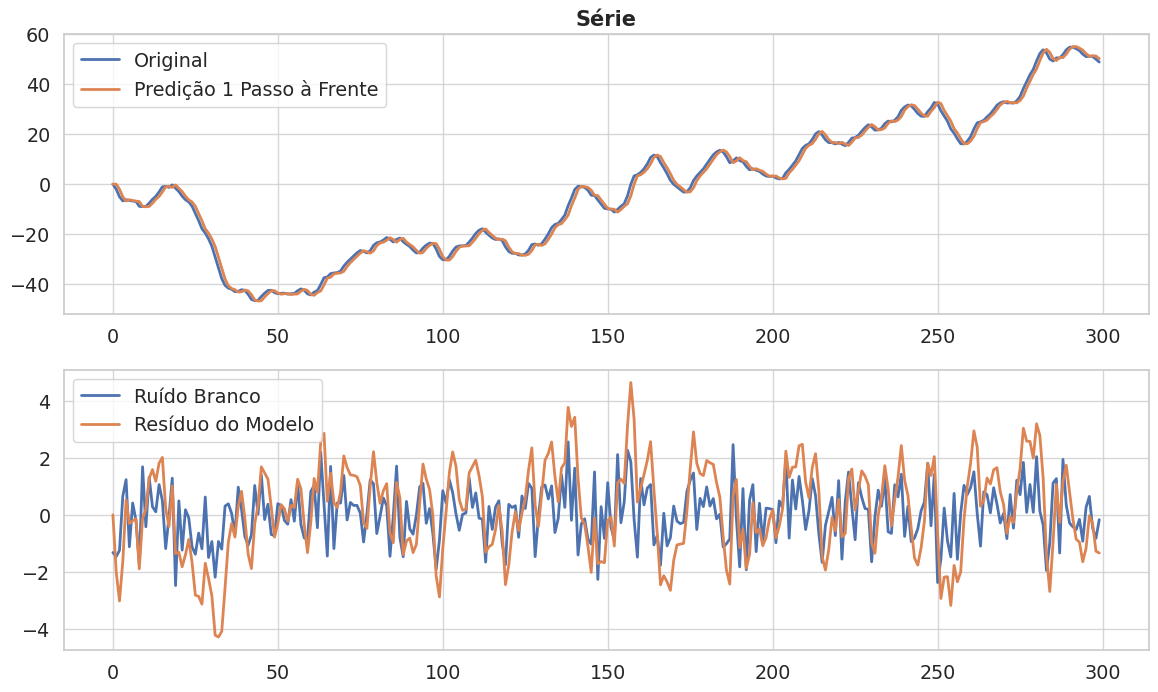

In [112]:
Y = y[1:]
X = np.hstack([y[:-1]])

W = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(Y)

y_pred = np.vstack([0, X.dot(W)])
r = y - y_pred

plot_osa(t, y, y_pred, e, r)
print_equation(f"{W[0][0]:+.2f} y[k-1]", r)


Equação estimada         ~  y[k] = +1.63 y[k-1] 
                                   -0.63 y[k-2]
                                   +0.34 e[k-1]
                                   +1.00 e[k]
Erro médio quadrático    ~  0.9592623340924316
AIC                      ~  844.3721
BIC                      ~  855.4834



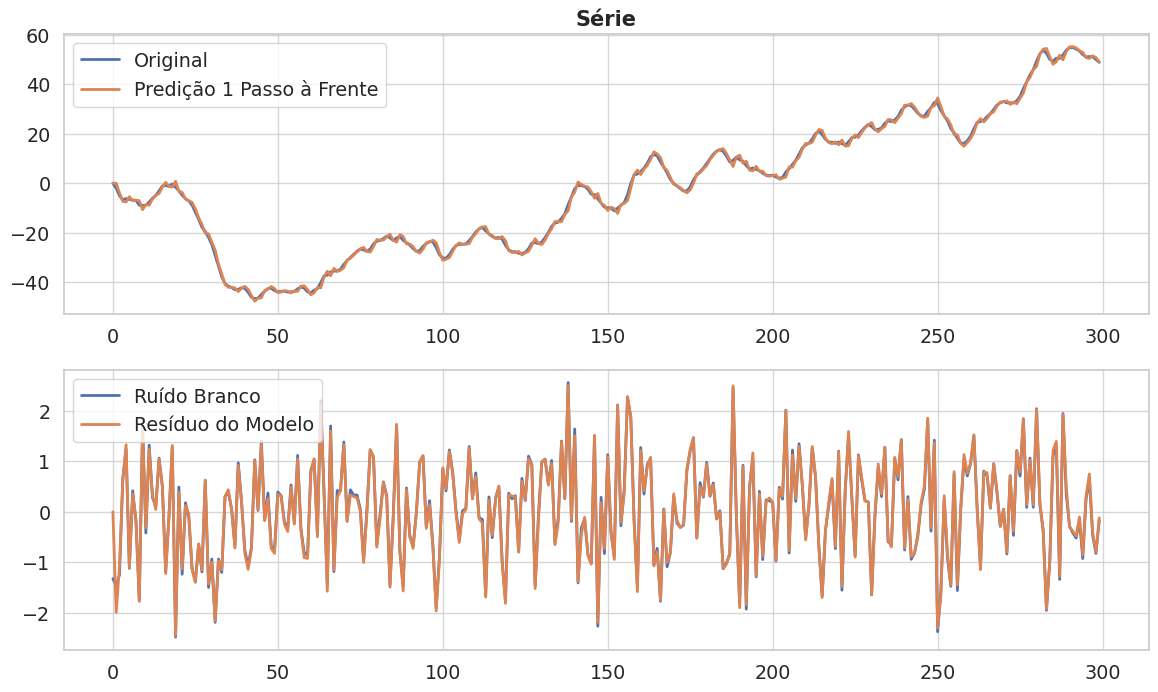

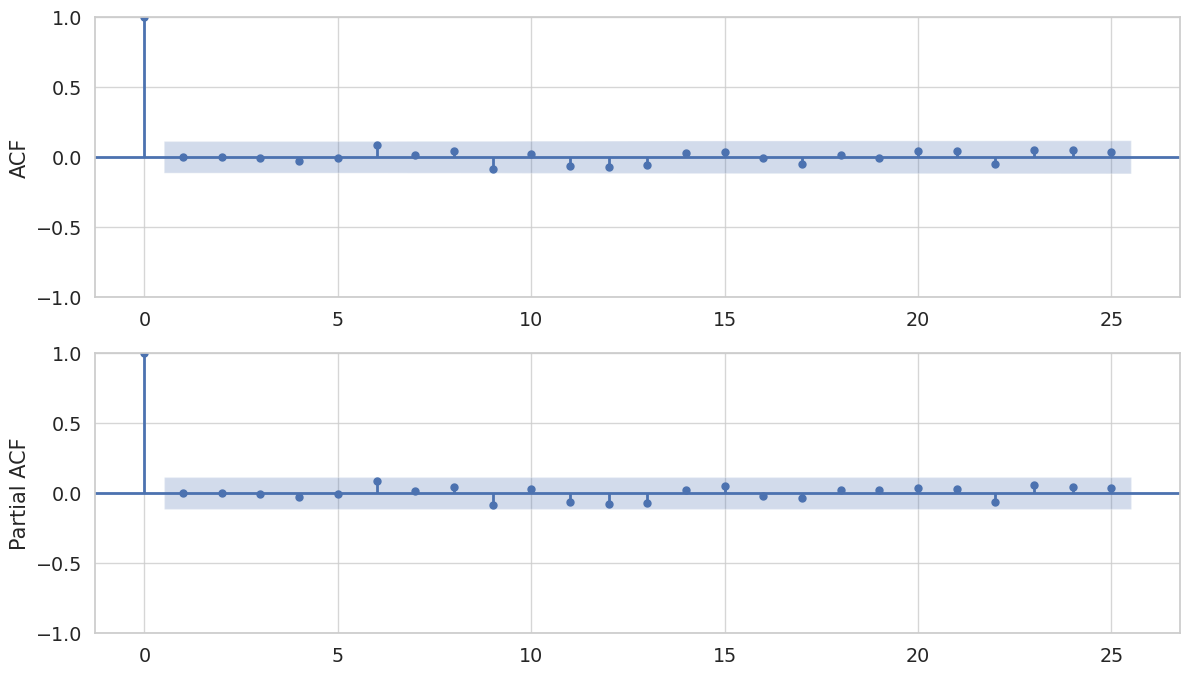

In [113]:
# Começamos assumindo que o resíduo é nulo
r = np.zeros_like(y)

# Inicializamos o vetor `target` (saída desejada)
Y = y[2:]

# Repetimos, 20 vezes, a estimativa dos parâmetros
for _ in range(20):
    X = np.hstack([y[1:-1], y[:-2], r[1:-1]])
    W = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(Y)
    y_pred = np.vstack([0, 0, X.dot(W)])
    r = y - y_pred

plot_osa(t, y, y_pred, e, r)
plot_corr(r)

print(f"""
Equação estimada         ~  y[k] = {W[0][0]:+.2f} y[k-1] 
                                   {W[1][0]:+.2f} y[k-2]
                                   {W[2][0]:+.2f} e[k-1]
                                   +1.00 e[k]
Erro médio quadrático    ~  {(r ** 2).mean()}
AIC                      ~  {aic(r, 3):.4f}
BIC                      ~  {bic(r, 3):.4f}
""")

Modelo ARMAX - Mínimos Quadrados Recursivos
-----------------------------------------------------------------------

\begin{equation}
    y_k = 0.5 y_{k-1} + 0.8 x_{k-1} + 0.4 \xi_{k-1} + \xi_k
\end{equation}

onde  
    $\xi_k \sim N(0, 1)$   
    $x_k \sim U(-1, 1)$  

Augmented Dickey-Fuller: Valor = -0.54, P-Value = 0.88


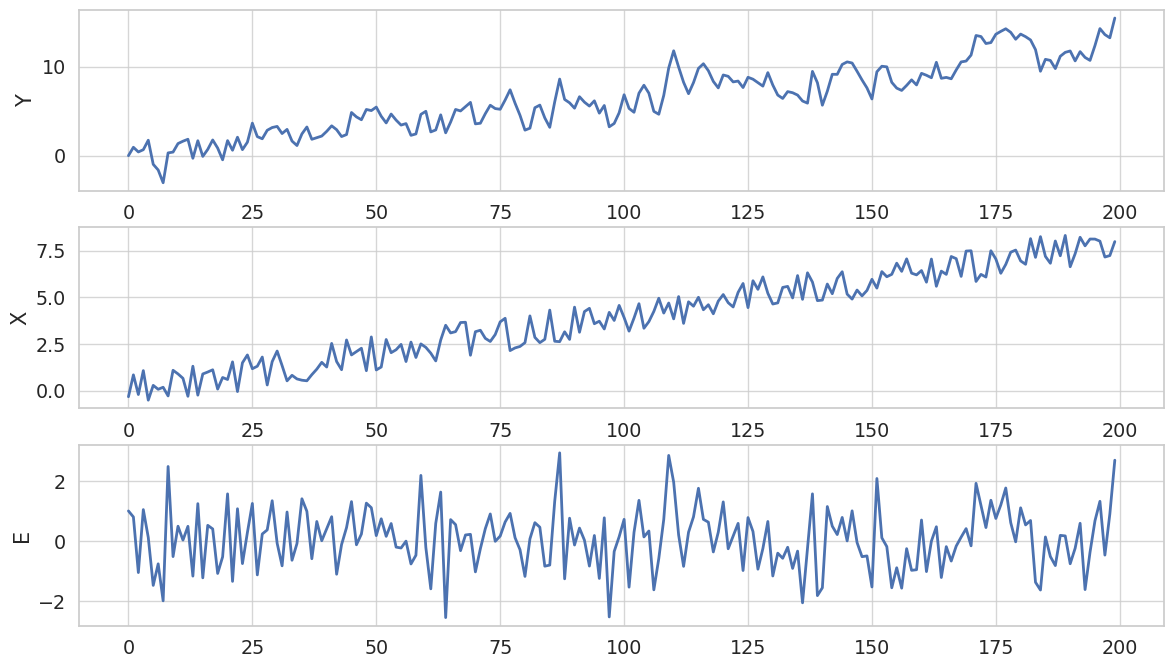

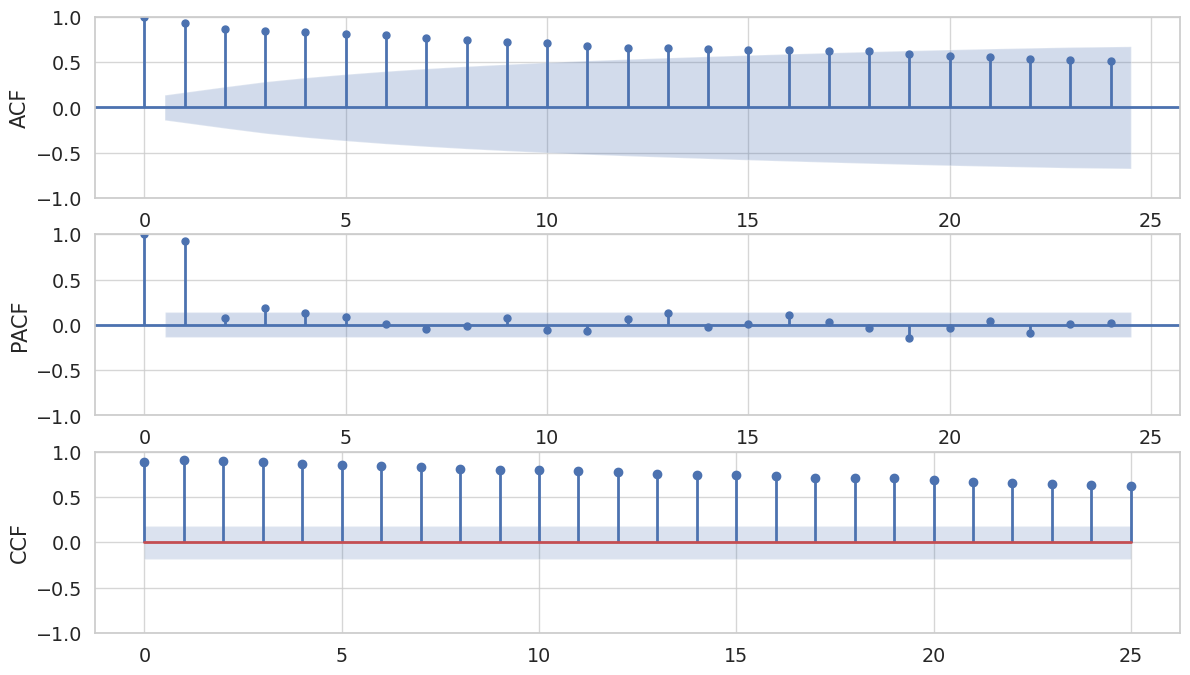

In [131]:
from statsmodels.tsa.stattools import ccf

random.seed(1442)
np.random.seed(1442)

samples = 200

t = np.arange(samples)
y = np.zeros((samples, 1))
x = np.random.rand(samples, 1) * 2 - 1 + t.reshape(-1, 1) * 0.04
e = np.random.randn(samples, 1)

for k in range(1, samples):
    y[k] = 0.5 * y[k-1] + 0.8 * x[k-1] + 0.4 * e[k-1] + e[k]

plt.subplot(311); plt.plot(t, y); plt.ylabel('Y')
plt.subplot(312); plt.plot(t, x); plt.ylabel('X')
plt.subplot(313); plt.plot(t, e); plt.ylabel('E')

def plot_cross(x, y, max_lags=26):
    cross_corr = ccf(x, y)[:max_lags]
    lags = np.arange(max_lags)
    conf = 2.578 / np.sqrt(len(x))
    
    plt.stem(lags, cross_corr); plt.ylabel("CCF");
    plt.fill_between(lags, conf, -conf, alpha=0.2)
    plt.ylim([-1, 1])

plt.figure()
ax = plt.subplot(311); plot_acf(y, ax=ax, title=""); plt.ylabel("ACF");
ax = plt.subplot(312); plot_pacf(y, ax=ax, title="", method="ywm"); plt.ylabel("PACF");
ax = plt.subplot(313); plot_cross(y, x)
print_aftest(y)



Augmented Dickey-Fuller  ~  Valor = -9.74, P-Value = 0.00
Equação estimada         ~  yp[k] = +1.00 y[k-1] -0.10 e[k-1]
Erro médio quadrático    ~  1.5508
AIC                      ~  656.2726
BIC                      ~  659.5709
    


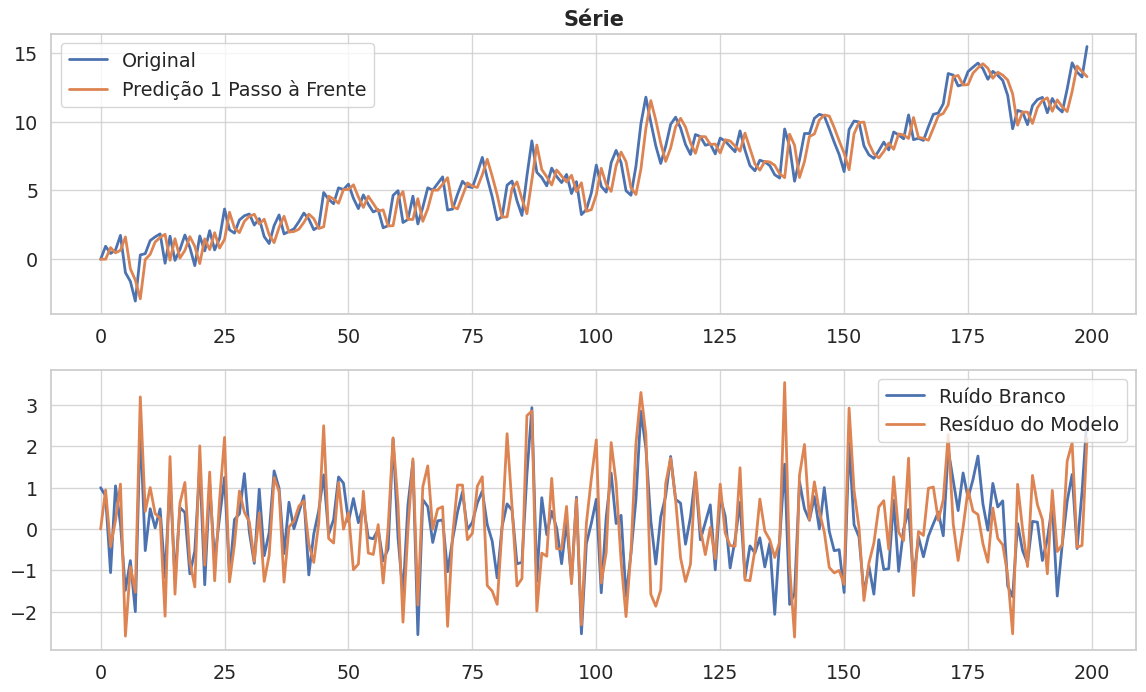

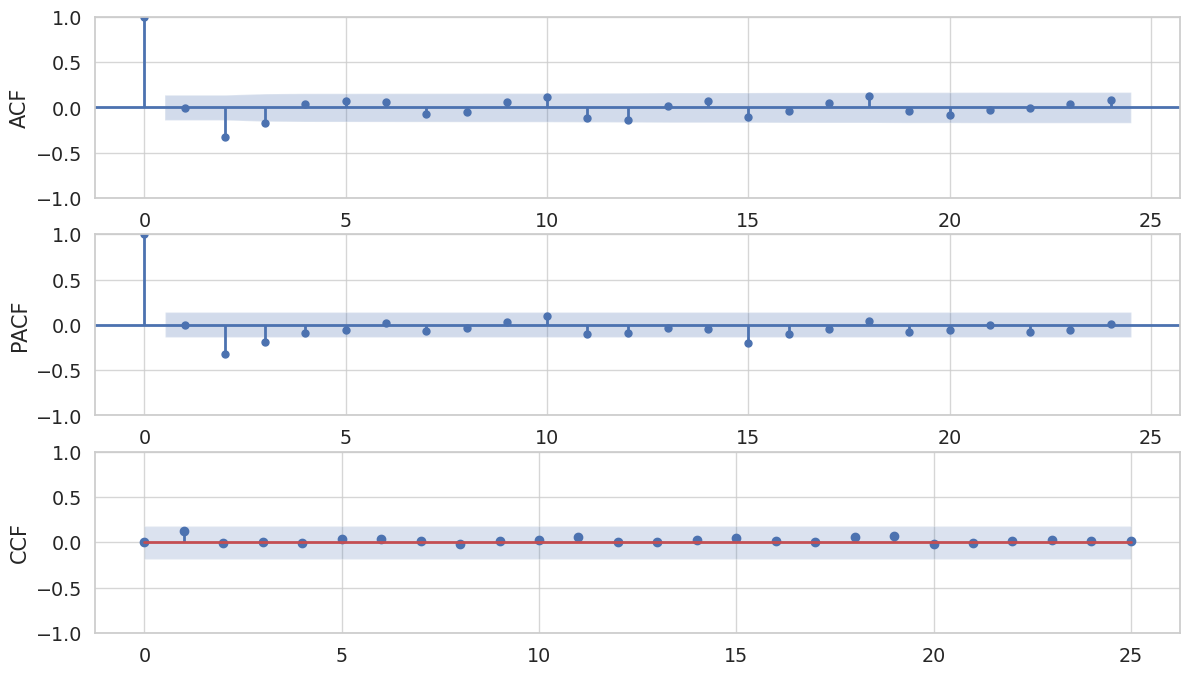

In [133]:
# Começamos assumindo que o resíduo é nulo
r = np.zeros_like(y)

# Inicializamos o vetor `target` (saída desejada)
Y = y[1:]

# Repetimos, 10 vezes, a estimativa dos parâmetros
for _ in range(20):
    X = np.hstack([y[:-1], r[:-1]])
    W = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(Y)
    y_pred = np.vstack([0, X.dot(W)])
    r = y - y_pred

plot_osa(t, y, y_pred, e, r)

plt.figure()
ax = plt.subplot(311); plot_acf(r, ax=ax, title=""); plt.ylabel("ACF");
ax = plt.subplot(312); plot_pacf(r, ax=ax, title="", method="ywm"); plt.ylabel("PACF");
ax = plt.subplot(313); plot_cross(r, x)
print_equation(f"{W[0][0]:+.2f} y[k-1] {W[1][0]:+.2f} e[k-1]", r)


Augmented Dickey-Fuller  ~  Valor = -5.62, P-Value = 0.00
Equação estimada         ~  yp[k] = +0.51 y[k-1] +0.81 x[k-1] +0.38 e[k-1]
Erro médio quadrático    ~  0.9937
AIC                      ~  568.2011
BIC                      ~  571.4994
    


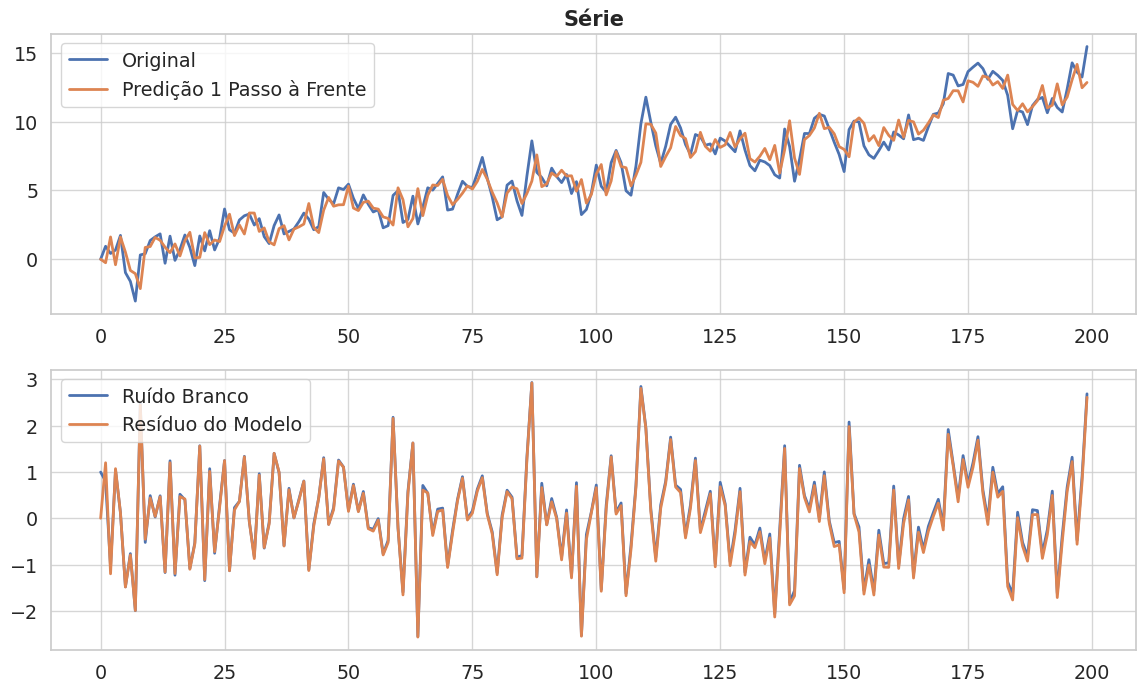

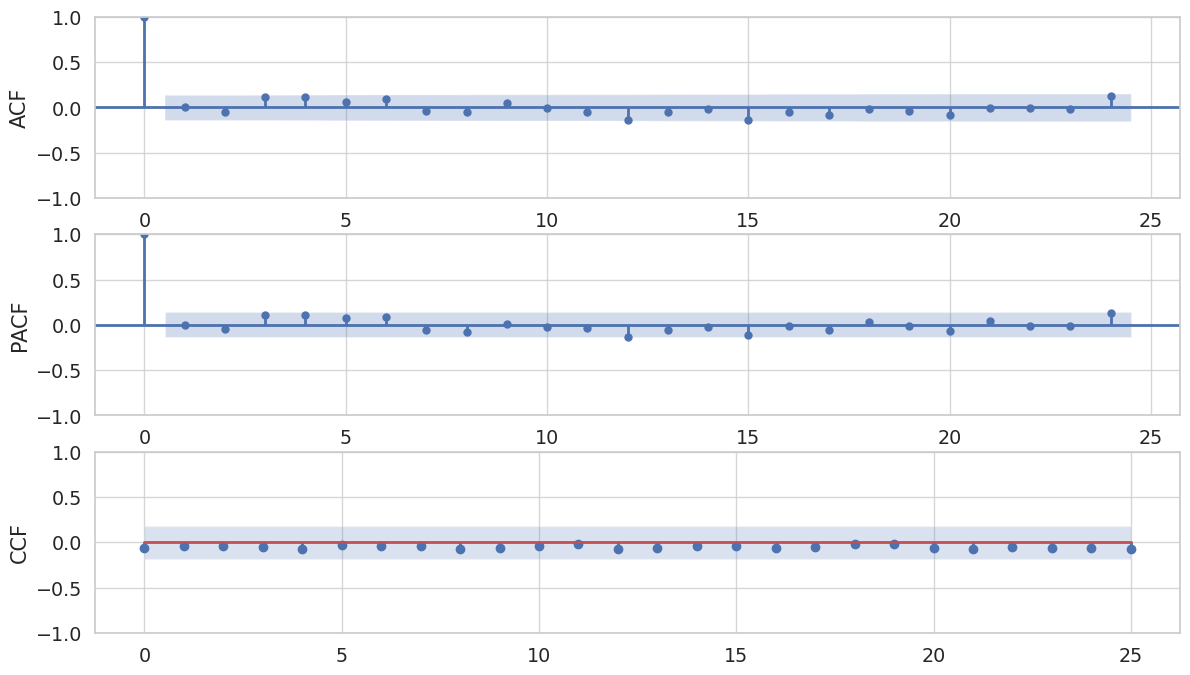

In [136]:
# Começamos assumindo que o resíduo é nulo
r = np.zeros_like(y)

# Inicializamos o vetor `target` (saída desejada)
Y = y[1:]

# Repetimos, 50 vezes, a estimativa dos parâmetros
for _ in range(50):
    X = np.hstack([y[:-1], x[:-1], r[:-1]])
    W = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(Y)
    y_pred = np.vstack([0, X.dot(W)])
    r = y - y_pred

plot_osa(t, y, y_pred, e, r)

plt.figure()
ax = plt.subplot(311); plot_acf(r, ax=ax, title=""); plt.ylabel("ACF");
ax = plt.subplot(312); plot_pacf(r, ax=ax, title="", method="ywm"); plt.ylabel("PACF");
ax = plt.subplot(313); plot_cross(r, x)
print_equation(f"{W[0][0]:+.2f} y[k-1] {W[1][0]:+.2f} x[k-1] {W[2][0]:+.2f} e[k-1]", r)

# Exemplo de transformação de Box-cox